In [5]:
from bs4 import BeautifulSoup as bs
import requests
import datetime
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt

## Сбор данных

In [3]:
url = "http://stopcovid.belta.by/"
header = {"user-agent": "Mozilla/5.0 (X11; Linux x86_64; rv:68.0) Gecko/20100101 Firefox/68.0"}
soup = bs(requests.get(url, headers=header).content, "html5lib")

In [6]:
died = soup.find("div", {"data-elem-id": "1587028275158"}).text # Умерли
recovered = soup.find("div", {"field": "tn_text_1587117956904"}).text.replace(" ", "") # Выздоровели и выписаны
infected = soup.find("div", {"field": "tn_text_1587028275132"}).text.replace(" ", "") # Зарегистрированы
tested = soup.find("div", {"field": "tn_text_1587028275139"}).text.replace(" ", "") # Проведено тестов
date_pub = re.match("^ОФИЦИАЛЬНЫЕДАННЫЕМИНЗДРАВАна6.00(\d\d\.\d\d\.\d\d\\d\d)г\.", soup.find("div", {"field": "tn_text_1592314133762"}).text.replace(" ", "")).group(1) # Дата публикации данных

In [7]:
datum = {"date_pub": date_pub, "tested": tested, "infected": infected, "recovered": recovered, "died": died}

In [5]:
with open("stopcovid_data.csv", "a") as f:
    field_names = datum.keys()
    csv_writer = csv.DictWriter(f, fieldnames=field_names)
    csv_writer.writerow(datum)

## Визуализация данных

In [2]:
def get_deltas(orig_series):
    result_series = [0]
    i = 0
    while i < orig_series.shape[0] - 1:
        delta = orig_series[i+1] - orig_series[i]
        if delta >= 0:
            result_series.append(delta)
        else:
            result_series.append(0)
        i+=1
    return result_series

In [3]:
plt.style.use("ggplot")
data = pd.read_csv("stopcovid_data.csv")

for column in data.drop("date_pub", axis=1).columns:
    data[column + "_dayly"] = get_deltas(data[column])

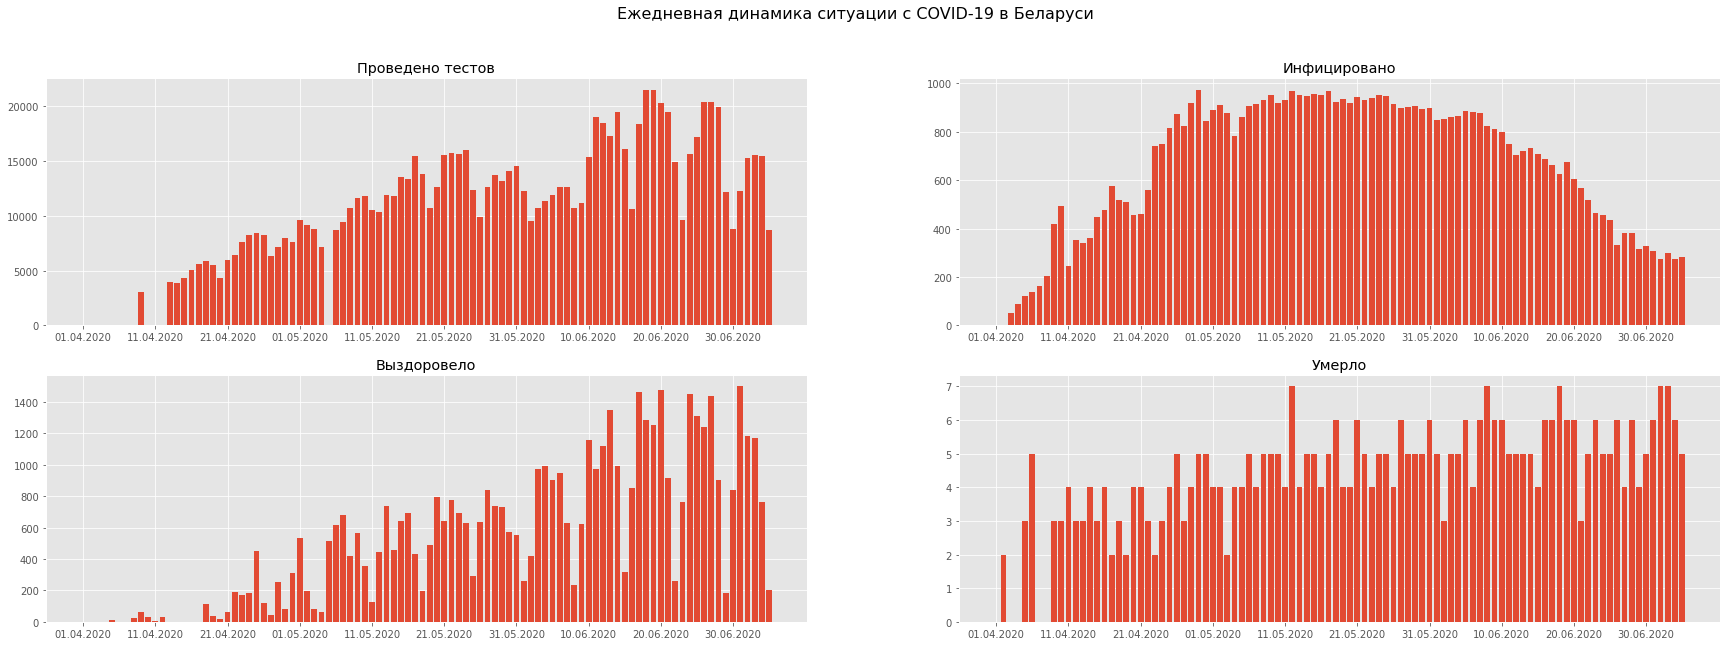

In [4]:
fig, ax = plt.subplots(2,2, figsize=(30,10));

plt.suptitle("Ежедневная динамика ситуации с COVID-19 в Беларуси", fontsize=16)

ax[0][0].bar(data["date_pub"], data["tested_dayly"]);
ax[0][0].set_ylim(0);
ax[0][0].set_title("Проведено тестов");
ax[0][0].set_xticks(data["date_pub"][::10])

ax[0][1].bar(data["date_pub"], data["infected_dayly"]);
ax[0][1].set_ylim(0);
ax[0][1].set_title("Инфицировано");
ax[0][1].set_xticks(data["date_pub"][::10]);

ax[1][0].bar(data["date_pub"], data["recovered_dayly"]);
ax[1][0].set_ylim(0);
ax[1][0].set_title("Выздоровело");
ax[1][0].set_xticks(data["date_pub"][::10]);

ax[1][1].bar(data["date_pub"], data["died_dayly"]);
ax[1][1].set_ylim(0);
ax[1][1].set_title("Умерло");
ax[1][1].set_xticks(data["date_pub"][::10]);

plt.savefig("./dayly_stats.png")

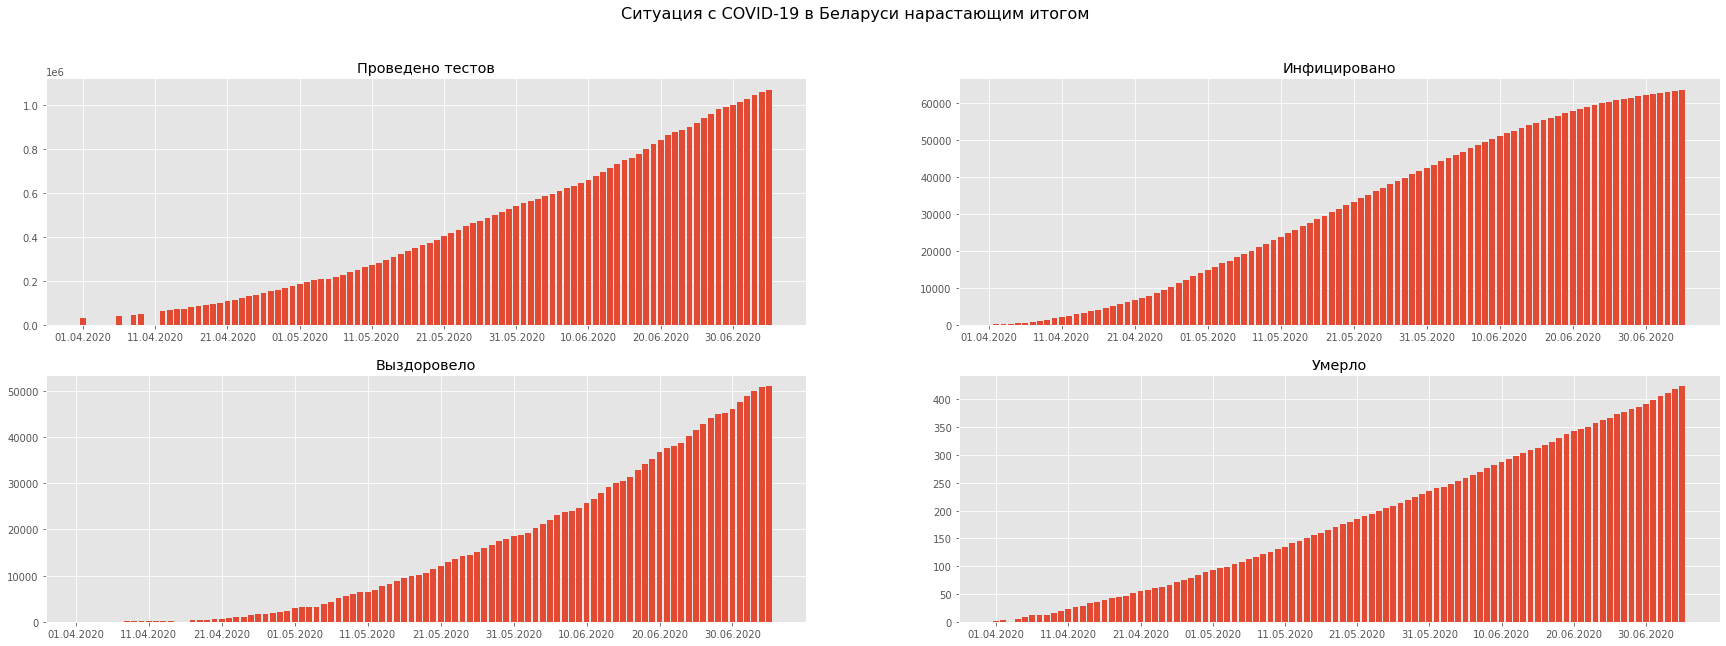

In [5]:
fig, ax = plt.subplots(2,2, figsize=(30,10));

plt.suptitle("Ситуация с COVID-19 в Беларуси нарастающим итогом", fontsize=16)

ax[0][0].bar(data["date_pub"], data["tested"]);
ax[0][0].set_ylim(0);
ax[0][0].set_title("Проведено тестов");
ax[0][0].set_xticks(data["date_pub"][::10])

ax[0][1].bar(data["date_pub"], data["infected"]);
ax[0][1].set_ylim(0);
ax[0][1].set_title("Инфицировано");
ax[0][1].set_xticks(data["date_pub"][::10]);

ax[1][0].bar(data["date_pub"], data["recovered"]);
ax[1][0].set_ylim(0);
ax[1][0].set_title("Выздоровело");
ax[1][0].set_xticks(data["date_pub"][::10]);

ax[1][1].bar(data["date_pub"], data["died"]);
ax[1][1].set_ylim(0);
ax[1][1].set_title("Умерло");
ax[1][1].set_xticks(data["date_pub"][::10]);